# First part: Using compressor of statnetencoder, so not sure if correct

## Dependencies & Hyperparameters

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE
import numpy as np
from pytorch_metric_learning import losses
import os
sys.path.append('../PooledStatisticsMetamers/poolstatmetamer/')
import utils.statnetencoder as sne
import importlib
import imp
import torch.nn.functional as F
from pytorch_lightning import seed_everything

#!wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py

#sys.path.append(r'C:\Users\chris\Documents\MIT\Statistics_analysis_code\PyTorchSteerablePyramid')
sys.path.append('../PyTorchSteerablePyramid/')
import steerable
import steerable.utils as utils
from steerable.SCFpyr_PyTorch import SCFpyr_PyTorch

seed_everything(0)

#use GPU 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

/tmp/ipykernel_3977183/645163111.py:16: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


[2023-10-06 18:51:54,957] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-10-06 18:51:55.500833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 18:51:56.507506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 0


In [2]:
#hyperparams
num_epochs = 100
batch_size = 1
crop_size = 128 
num_stats = 50 
optimizer_type='adam'
#optimizer_type='sgd'
learning_rate = 0.001
num_crops = 5 #changed this to four

multistat_penalty = 0
sparsity_penalty = 0 #0.01
entropic_penalty = 0

## Create Dataset and define DataLoader

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import os

class KTHImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Filtering only directories for classes
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)

            # Scanning for image files directly in the class folder
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)

                if os.path.isfile(img_path):  # Checking if it's a file
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Specify transformations
loading_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((200, 200)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.FiveCrop(size=crop_size), 
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # Changed PILToTensor to ToTensor as it's more standard
    transforms.ConvertImageDtype(torch.float32)
])

# Initialize dataset and dataloader
sys.path.append('../data/KTH_output/kth-tips2-b_col_200x200/KTH-TIPS2-b')

root_dir = '../data/KTH_output/kth-tips2-b_col_200x200/KTH-TIPS2-b'
dataset = KTHImageDataset(root_dir=root_dir, transform=loading_transforms)
kth_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [4]:
import utils.brucenet as bn
brucy = bn.BruceNet(pooling_region_size=1e20, pyramid_params=False, dummy_img = torch.zeros(20,
                                     1,
                                     128,
                                     128)).to(device)


/anaconda/envs/pytorch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


In [5]:
all_statistics = []

for j, (texture_batch, labels) in enumerate(kth_dataloader):
    # Assuming texture_batch has a shape of [20, 5, 1, 128, 128]
    #print(texture_batch.shape)
    for i in range(texture_batch.shape[0]):  # Loop over batch
        mini_batch = texture_batch[i]  # This should have a shape of [5, 1, 128, 128]
        mini_batch = mini_batch.to(device)

        # Now you can call brucy, which expects a tensor with shape x,1,128,128 where x > 1
        statistics = brucy(mini_batch)  # This should output a tensor of shape [5, 150]
        
        # You can now store these statistics, along with the label and original image index
        all_statistics.append({
            'statistics': statistics.cpu().numpy(),
            #'label': labels[i].item(),
            'original_image_index': j * texture_batch.shape[0] + i
        })



In [6]:
statistics_array = np.array([item['statistics'] for item in all_statistics])
print(statistics_array.shape)
num_stats = statistics_array.shape[2]
print(num_stats)

(4752, 5, 150)
150


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Convert the list of dictionaries to a NumPy array or PyTorch tensor
statistics_array = np.array([item['statistics'] for item in all_statistics])
#print(statistics_array.shape)
labels_array = np.array([item['original_image_index'] for item in all_statistics])
# Standardize
scaler = StandardScaler()

reshaped_array = statistics_array.reshape(-1,num_stats)
#print(reshaped_array.shape)
scaled_array = scaler.fit_transform(reshaped_array)

statistics_array = scaled_array.reshape(len(dataset), 5, num_stats)
statistics_tensor = torch.tensor(statistics_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)


In [8]:
ostat_labels = ['mean', 'variance', 'bandpass_variance 0', 'variance 1', 'skew 1', 'kurtosis 1', 'variance 2', 'skew 2', 'kurtosis 2', 'variance 3', 'skew 3', 'kurtosis 3', 'variance 4', 'skew 4', 'kurtosis 4', 'variance 5', 'skew 5', 'kurtosis 5', 'edge_mean 1 0', 'edge_variance 1 0', 'edge_correlation (1, 2) 0', 'edge_stop 1 0', 'edge_mean 1 1', 'edge_variance 1 1', 'edge_correlation (1, 2) 1', 'edge_stop 1 1', 'edge_mean 1 2', 'edge_variance 1 2', 'edge_correlation (1, 2) 2', 'edge_stop 1 2', 'edge_mean 1 3', 'edge_variance 1 3', 'edge_correlation (1, 2) 3', 'edge_stop 1 3', 'edge_correlation 1 (0, 1)', 'edge_correlation 1 (0, 2)', 'edge_correlation 1 (0, 3)', 'edge_correlation 1 (1, 2)', 'edge_correlation 1 (1, 3)', 'edge_correlation 1 (2, 3)', 'edge_mean 2 0', 'edge_variance 2 0', 'edge_correlation (2, 3) 0', 'edge_stop 2 0', 'edge_mean 2 1', 'edge_variance 2 1', 'edge_correlation (2, 3) 1', 'edge_stop 2 1', 'edge_mean 2 2', 'edge_variance 2 2', 'edge_correlation (2, 3) 2', 'edge_stop 2 2', 'edge_mean 2 3', 'edge_variance 2 3', 'edge_correlation (2, 3) 3', 'edge_stop 2 3', 'edge_correlation 2 (0, 1)', 'edge_correlation 2 (0, 2)', 'edge_correlation 2 (0, 3)', 'edge_correlation 2 (1, 2)', 'edge_correlation 2 (1, 3)', 'edge_correlation 2 (2, 3)', 'edge_mean 3 0', 'edge_variance 3 0', 'edge_correlation (3, 4) 0', 'edge_stop 3 0', 'edge_mean 3 1', 'edge_variance 3 1', 'edge_correlation (3, 4) 1', 'edge_stop 3 1', 'edge_mean 3 2', 'edge_variance 3 2', 'edge_correlation (3, 4) 2', 'edge_stop 3 2', 'edge_mean 3 3', 'edge_variance 3 3', 'edge_correlation (3, 4) 3', 'edge_stop 3 3', 'edge_correlation 3 (0, 1)', 'edge_correlation 3 (0, 2)', 'edge_correlation 3 (0, 3)', 'edge_correlation 3 (1, 2)', 'edge_correlation 3 (1, 3)', 'edge_correlation 3 (2, 3)', 'edge_mean 4 0', 'edge_variance 4 0', 'edge_stop 4 0', 'edge_mean 4 1', 'edge_variance 4 1', 'edge_stop 4 1', 'edge_mean 4 2', 'edge_variance 4 2', 'edge_stop 4 2', 'edge_mean 4 3', 'edge_variance 4 3', 'edge_stop 4 3', 'edge_correlation 4 (0, 1)', 'edge_correlation 4 (0, 2)', 'edge_correlation 4 (0, 3)', 'edge_correlation 4 (1, 2)', 'edge_correlation 4 (1, 3)', 'edge_correlation 4 (2, 3)', 'phase_correlation 1 er (0, 1)', 'phase_correlation 1 er (0, 2)', 'phase_correlation 1 er (0, 3)', 'phase_correlation 1 er (1, 2)', 'phase_correlation 1 er (1, 3)', 'phase_correlation 1 er (2, 3)', 'phase_correlation (1, 2) ei*di 0', 'phase_correlation (1, 2) er*di 0', 'phase_correlation (1, 2) ei*di 1', 'phase_correlation (1, 2) er*di 1', 'phase_correlation (1, 2) ei*di 2', 'phase_correlation (1, 2) er*di 2', 'phase_correlation (1, 2) ei*di 3', 'phase_correlation (1, 2) er*di 3', 'phase_correlation 2 er (0, 1)', 'phase_correlation 2 er (0, 2)', 'phase_correlation 2 er (0, 3)', 'phase_correlation 2 er (1, 2)', 'phase_correlation 2 er (1, 3)', 'phase_correlation 2 er (2, 3)', 'phase_correlation (2, 3) ei*di 0', 'phase_correlation (2, 3) er*di 0', 'phase_correlation (2, 3) ei*di 1', 'phase_correlation (2, 3) er*di 1', 'phase_correlation (2, 3) ei*di 2', 'phase_correlation (2, 3) er*di 2', 'phase_correlation (2, 3) ei*di 3', 'phase_correlation (2, 3) er*di 3', 'phase_correlation 3 er (0, 1)', 'phase_correlation 3 er (0, 2)', 'phase_correlation 3 er (0, 3)', 'phase_correlation 3 er (1, 2)', 'phase_correlation 3 er (1, 3)', 'phase_correlation 3 er (2, 3)', 'phase_correlation (3, 4) ei*di 0', 'phase_correlation (3, 4) er*di 0', 'phase_correlation (3, 4) ei*di 1', 'phase_correlation (3, 4) er*di 1', 'phase_correlation (3, 4) ei*di 2', 'phase_correlation (3, 4) er*di 2', 'phase_correlation (3, 4) ei*di 3', 'phase_correlation (3, 4) er*di 3', 'phase_correlation 4 er (0, 1)', 'phase_correlation 4 er (0, 2)', 'phase_correlation 4 er (0, 3)', 'phase_correlation 4 er (1, 2)', 'phase_correlation 4 er (1, 3)', 'phase_correlation 4 er (2, 3)']

In [9]:
from torch.utils.data import Dataset, DataLoader

class StatisticsDataset(Dataset):
    def __init__(self, statistics_tensor, labels_tensor):
        self.statistics = statistics_tensor
        self.labels = labels_tensor
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.statistics[idx], self.labels[idx]

# Create the dataset object
statistics_dataset = StatisticsDataset(statistics_tensor, labels_tensor)


In [10]:
# Create the DataLoader object first
batches = 100
statistics_dataloader = DataLoader(statistics_dataset, batch_size=batches, shuffle=True)

# Loop through a couple of batches
if(False):
    for i, (stats_batch, label_batch) in enumerate(statistics_dataloader):
        if i > 1:  # We only want to look at a couple of batches
            break

        print(f"Batch {i + 1}")

        # Dimensionality Check
        print("Statistics Batch Shape:", stats_batch.shape)  
        print("Label Batch Shape:", label_batch.shape)

        # Data Type Check
        print("Statistics Data Type:", stats_batch.dtype)
        print("Label Data Type:", label_batch.dtype)

        # Label Consistency (and value preview)
        print("Statistics:", stats_batch)
        print("Labels:", label_batch)


In [11]:
importlib.reload(sne)
statnet_model = sne.StatNetEncoder(img_size=(crop_size,crop_size),
                                   batch_size=batch_size,
                                   num_stats=num_stats,
                                   device=device)
stat_labels = statnet_model.getsstatlabels(device)
#optimizer
if(optimizer_type=='sgd'):
    optimizer = torch.optim.SGD(statnet_model.parameters(), lr=learning_rate)#, momentum=learning_momentum)
elif(optimizer_type=='adam'):
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adagrad'):
    optimizer = torch.optim.Adagrad(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adadelta'):
    optimizer = torch.optim.Adadelta(statnet_model.parameters(), lr=learning_rate)
else:
    print('No Optimizer Specified! Adam is default!')
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)

Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


In [12]:
print('Total Stats:',len(stat_labels))
summation=0
for stat in ['edge_mean','edge_variance','edge_stop','edge_correlation','phase_correlation','mean','variance','bandpass_variance','skew','kurtosis']:
    num_this_stat = len([s for s in stat_labels if s.weight_category==stat])
    print(f'{stat} Stat:',num_this_stat)
    summation += num_this_stat
print('Stats Sum to:',summation)
#[s for s in stat_labels] #print all stats with details

Total Stats: 150
edge_mean Stat: 16
edge_variance Stat: 16
edge_stop Stat: 16
edge_correlation Stat: 36
phase_correlation Stat: 48
mean Stat: 1
variance Stat: 6
bandpass_variance Stat: 1
skew Stat: 5
kurtosis Stat: 5
Stats Sum to: 150


### Also serves as a pretrained model for the next approach

In [47]:
### Try with a single layer for the original approach

class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_stats, 50)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = self.layer1(self.dropout(x))
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=50, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [97]:
loss_func_contrastive = losses.GeneralizedLiftedStructureLoss()
model = EmbeddingModel()
model.to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
training_loss = []
training_representation_loss = []
training_sparsity_loss = []
num_epochs = 200
num_total_epochs = 0
#[s for s in stat_labels] #print all stats with details
model.train() # Set model to training mode
optimizer.zero_grad()
model.zero_grad()

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=50, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [98]:
import time
start_time = time.time()
print('Starting Training:')
for i, epoch in enumerate(range(num_epochs)):
    for stats_batch, label_batch in statistics_dataloader:
        optimizer.zero_grad()

        #grab texture batch and generate matching labels
        stats_batch = stats_batch.to(device)
        if stats_batch.shape[0] < batches:
            continue 
        #print(stats_batch.shape)
        stats_batch_2 = torch.flatten(stats_batch, start_dim=0, end_dim=1)
        #print(stats_batch.shape) #torch.Size([batch_size, 5, 150])
        #print(label_batch) #label array of size batch_size containing image index
        texture_labels = torch.repeat_interleave(torch.arange(batches),num_crops).to(device)


        stats_vector = model(stats_batch_2)
        #loss definitions
        representation_loss = loss_func_contrastive(stats_vector, texture_labels)
        loss = representation_loss 
        #loss = triplet_loss(stats_vector, texture_labels, texture_labels)
        
        loss.backward()
        optimizer.step()

        print('*',end='')
        #training_loss.append(loss.item())      
        if(j%10==0):
            print(loss.item())
        if(j==1000):
            break; 
        training_loss.append(loss.item())
    num_total_epochs = num_total_epochs + 1
    print(f'Finished Epoch {i}. Loss at {loss}.')
    #print('Initial Weights:', statnet_model._w)    
    if(i==1100):
        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        # Run t-SNE in PyTorch
        transformed = TorchTSNE(n_components=2).fit_transform(stats_vector_cpu)

        plt.figure(figsize=(8, 8))
        for label in np.unique(texture_labels_cpu):
            indices = np.where(texture_labels_cpu == label)
            x = transformed[indices, 0].squeeze()
            y = transformed[indices, 1].squeeze()
            plt.scatter(x, y, label=str(label))

            # Annotate each point with its label
            for i, (xi, yi) in enumerate(zip(x, y)):
                plt.annotate(str(label), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

        plt.legend()
        plt.title(f"t-SNE visualization at epoch {i}")
        plt.show()
print('All Done!')
print("--- %s seconds ---" % (time.time() - start_time))
torch.save(model.state_dict(), 'contrastive_model_HB_KTH.pth')


Starting Training:
***********************************************Finished Epoch 0. Loss at 8.124319076538086.
***********************************************Finished Epoch 1. Loss at 7.9645819664001465.
***********************************************Finished Epoch 2. Loss at 7.93113374710083.
***********************************************Finished Epoch 3. Loss at 7.8672590255737305.
***********************************************Finished Epoch 4. Loss at 7.835411071777344.
***********************************************Finished Epoch 5. Loss at 7.830404758453369.
***********************************************Finished Epoch 6. Loss at 7.797580242156982.
***********************************************Finished Epoch 7. Loss at 7.812541484832764.
***********************************************Finished Epoch 8. Loss at 7.854471206665039.
***********************************************Finished Epoch 9. Loss at 7.7466559410095215.
***********************************************Finished Epo

In [99]:
stats_batch_2.shape

torch.Size([500, 150])

In [100]:
import shap

model = model.eval().cpu()

def sim_func(mask):
    with torch.no_grad():

        mask = torch.tensor(mask).to(torch.float32)

        print(mask.shape)
        stats = stats_batch_2.reshape(batches, num_crops, num_stats).cpu()
        print(stats.shape)
        d, c2 = mask.shape
        assert num_stats == c2
        masked_stats = (torch.einsum("bnc,dc->bdnc", stats, mask)
                        .reshape(batches * d * num_crops, num_stats))

        embs = (model
                .forward(masked_stats)
                .reshape(batches, d, num_crops, -1))

        return (torch.einsum("bdnc,bdmc->bdnm", embs, embs)
                .mean(dim=[0, 2, 3])
                .unsqueeze(-1).numpy())

reference = np.zeros((1, num_stats))
input = np.ones((1, num_stats))
explainer = shap.KernelExplainer(
    sim_func,
    reference
)

shap_values = np.abs(explainer.shap_values(input)[0].squeeze())

torch.Size([1, 150])
torch.Size([100, 5, 150])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 150])
torch.Size([100, 5, 150])
torch.Size([2348, 150])
torch.Size([100, 5, 150])


In [101]:
print(stats_batch_2.shape, texture_labels.shape, stats_vector.shape)

torch.Size([500, 150]) torch.Size([500]) torch.Size([500, 50])


In [102]:
np.savez_compressed("example_inputs.npz", stats=stats_batch_2.reshape(batches, num_crops, -1).detach().cpu(),
                    labels=texture_labels.reshape(batches, num_crops).detach().cpu())

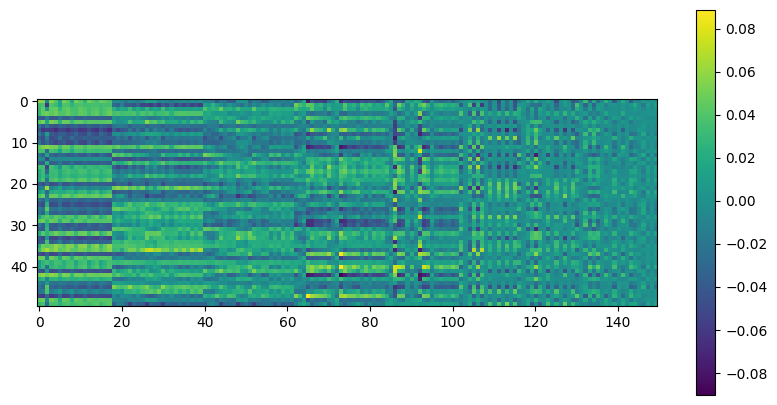

In [104]:
weights_layer1 = model.layer1.weight.data
# Converting the tensor to a NumPy array
compressor_mat = weights_layer1.cpu().numpy()
#print(compressor_mat.shape)

plt.figure(figsize=(10,5))
plt.imshow(compressor_mat)
plt.colorbar()
#print(compressor_mat)

Most Important 25 Stats:
2.1226976 edge_stop 4 0
1.9923149 kurtosis 5
1.9686922 variance
1.9544301 skew 2
1.9358172 skew 3
1.9323691 skew 1
1.9239085 kurtosis 4
1.9078273 variance 1
1.8613373 edge_stop 4 2
1.8474388 edge_stop 3 2
1.8237562 skew 4
1.8178327 variance 2
1.7972769 skew 5
1.7727662 kurtosis 3
1.6946715 variance 3
1.6244491 variance 4
1.5949732 phase_correlation 2 er (1, 3)
1.5926442 edge_mean 3 1
1.5569253 variance 5
1.5538214 edge_mean 4 3
1.5486659 edge_stop 3 0
1.5308117 edge_mean 3 3
1.5049361 kurtosis 2
1.4789243 edge_mean 4 1
1.4110479 edge_mean 3 2


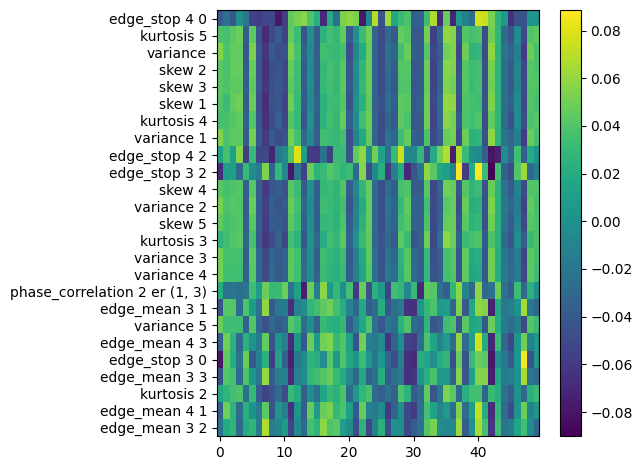

Least Important 25 Stats:
0.050560363 phase_correlation (1, 2) ei*di 1
0.05159436 phase_correlation (2, 3) ei*di 3
0.053600203 phase_correlation (2, 3) ei*di 1
0.06339769 phase_correlation (2, 3) ei*di 0
0.07953618 phase_correlation (1, 2) ei*di 0
0.082511105 phase_correlation 1 er (0, 2)
0.08421414 phase_correlation 4 er (1, 3)
0.084401615 phase_correlation (1, 2) ei*di 3
0.09588146 phase_correlation (3, 4) ei*di 1
0.09667712 phase_correlation (3, 4) ei*di 3
0.11615746 phase_correlation 2 er (0, 2)
0.12245869 phase_correlation (2, 3) ei*di 2
0.14166464 phase_correlation (3, 4) ei*di 2
0.14396264 phase_correlation (3, 4) ei*di 0
0.14463353 phase_correlation (1, 2) ei*di 2
0.17731832 phase_correlation 3 er (0, 2)
0.19047324 phase_correlation 4 er (0, 2)
0.31302473 edge_stop 4 3
0.35622662 phase_correlation 4 er (1, 2)
0.38065442 edge_stop 4 1
0.4012328 phase_correlation 4 er (2, 3)
0.44149515 edge_variance 4 2
0.442025 phase_correlation 4 er (0, 3)
0.4423064 edge_variance 4 0
0.4850165 

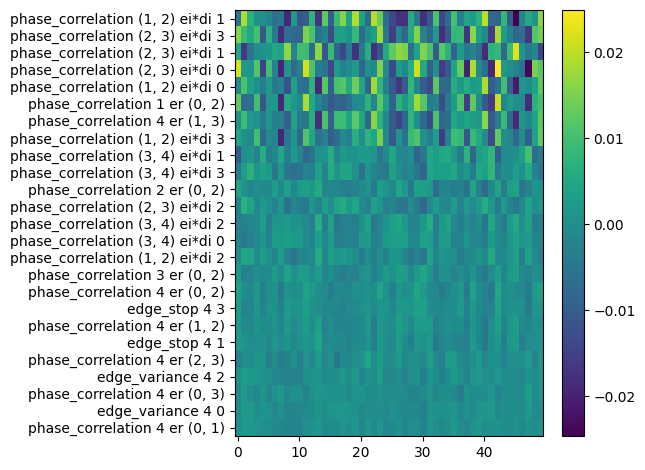

In [105]:
stat_sums = np.sum(np.abs(compressor_mat),axis=0) #how weighted is each of the 150 stats?
# stat_sums =shap_values
stat_index_array = np.argsort(stat_sums)[::-1] #get their importance order

ordered_stat_sums = stat_sums[stat_index_array]
ordered_stat_labels = np.array(stat_labels,dtype=object)[stat_index_array]
ordered_stats_labels_pretty = [' '.join([''.join(str(item)) for item in row if item not in ['',None]]) for row in ordered_stat_labels]

n=25
print(f'Most Important {n} Stats:')
for i in range(n):
    print(ordered_stat_sums[i],ordered_stats_labels_pretty[i])

#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)), labels=top_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    
    
#plot most important stats for contrastive learning
#plt.imshow(compressor_mat[:,stat_index_array[:n]].T)

print(f'Least Important {n} Stats:')
for i in range(1,n+1):
    print(ordered_stat_sums[-i],ordered_stats_labels_pretty[-i])
    
    
#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[-n:]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
bot_stats = ordered_stats_labels_pretty[-n:][::-1]
ax.set_yticks(np.arange(len(bot_stats)), labels=bot_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    

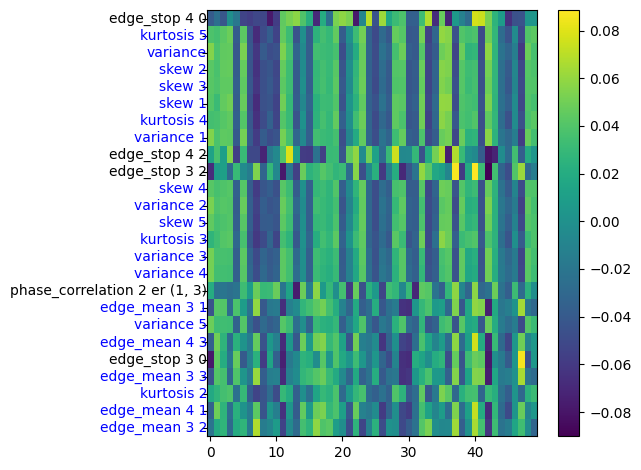

In [106]:

fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)

top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)))  # Only set the ticks, not the labels
ax.set_yticklabels([])  # Suppress the default ytick labels

# Place the ytick labels using ax.text and color those containing "kurtosis" or "mean"
for i, label in enumerate(top_stats):
    color = 'blue' if 'variance' in label or 'mean' in label or 'kurtosis' in label or 'skew' in label else 'black'
    ax.text(-0.5, i, label, va='center', ha='right', color=color)

plt.tight_layout()
plt.show()

In [107]:
variance = [i for i, label in enumerate(ostat_labels) if 'variance' in label]
mean = [i for i, label in enumerate(ostat_labels) if 'mean' in label]
skew = [i for i, label in enumerate(ostat_labels) if 'skew' in label]
kurtosis = [i for i, label in enumerate(ostat_labels) if 'kurtosis' in label]

heegerbergen_indices = variance + mean + skew + kurtosis

all_indices = set(range(len(ostat_labels)))
remaining_indices = sorted(list(all_indices - set(heegerbergen_indices)))
#print(remaining_indices)
#print(len(combined_indices))
#print(stat_index_array)
# Convert the numpy array to a list for easier indexing
stat_index_list = list(stat_index_array)

# Compute the ranks/positions
ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Computing the median rank
ranks_sorted = sorted(ranks)
length = len(ranks_sorted)

if length % 2 == 1:  # odd number of ranks
    median_rank = ranks_sorted[length // 2]
else:  # even number of ranks
    median_rank = (ranks_sorted[length // 2 - 1] + ranks_sorted[length // 2]) / 2

print(median_rank)  #@Mark: This should print 49.5

# Checking the intersection of the first 75 elements with heegerbergen_indices
count = sum(1 for index in stat_index_array[:15] if index in heegerbergen_indices)

print(count)

32.5
12


In [108]:
# Compute the ranks
stat_index_list = list(stat_index_array)

ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Compute the mean rank
mean_rank = sum(ranks) / len(ranks) if ranks else None

print(mean_rank)  # @Mark: This should print 52.6



46.34
